In [1]:
from TCSPC import *

In [2]:
EGFP = Simulation([0.497,0.503],[2.43,3.07])

In [3]:
# tdata = np.loadtxt('EGFPt.csv')
# ydata = np.loadtxt('EGFPy2.csv')

In [4]:
def trim_rescale_data(tdata,ydata,end =int(0.6*380),rescale = True):
    max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
    tdata = tdata[:end-max_idx] #start from t = 0
    ydata = ydata[max_idx:end]  #start from max.
    if rescale == True:
        yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
        ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
    else:
        yerr = np.sqrt(ydata)
    weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
    return tdata,ydata,weights

In [187]:
def trim_rescale_data(tdata,ydata,r = 0.1,end =int(0.6*380),rescale = True):
    '''Trim and rescale data (if rescale ==True)
       tdata    EGFP.t
       ydata    EGFP.y2 
       r        select points with y>r*max(y)
       rescale  True to rescale, False won't rescale'''
     #select points >r* max ydata only
    ydata = ydata[ydata>r*np.max(ydata)]
    #trim away IRF
    ydata = ydata[np.argmax(ydata):]
    #set tdata to same length, start from t = 0
    tdata = tdata[:len(ydata)]
    if rescale == True:
        yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
        ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
    else:
        yerr = np.sqrt(ydata)
    weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
    return tdata,ydata,weights

In [5]:
def exp(t, A, tau):
    return A * np.exp(-t/tau)

In [153]:
np.argmax(ydata)

0

In [159]:
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2)
len(tdata)

83

In [168]:
def poisson_deviance_residual(observed, expected):
    residual=  np.sqrt(abs(2 *  (observed* np.log(observed/ expected) - (observed- expected)))) #residual array
    return residual

def residual(p, t, data):
    v = p.valuesdict()
    expected = 0
    if 'c' in v:
        expected = v['c'] #constant background
    M = 1
    while f'A{M}' in v:
        expected += exp(t, v[f'A{M}'], v[f'tau{M}']) #add exponential component
        M += 1
    if 'A0' in v:
        expected *= v['A0'] #overall scaling factor if data is not rescaled
    return poisson_deviance_residual(data, expected) #lmfit.minimizer minimize the residual array in the sum of squared sense


In [44]:
def initial_params(M,A_guess,tau_guess,c_guess = 0,rescale = True,bg_removed = False):
    p = lmfit.Parameters()
    if bg_removed == False:
        p.add_many(('c', c_guess, True, 0)) #constant background
    if rescale == False:
        for i in range(M+1): #for each component
            p.add_many((f'A{i}', A_guess[i], True,0)) #amplitude
    else: 
        for i in range(1,M+1): #for each component
            p.add_many((f'A{i}', A_guess[i-1], True,0)) #amplitude
    for i in range(1,M+1):
        p.add_many((f'tau{i}', tau_guess[i-1], True, 0)) #lifetime
    p[f'A{M}'].set(expr = f'1 {"".join([f"- A{i}" for i in range(1,M)])}') #fix the amplitude of last component
    return p



In [78]:
def initial_params(M,A_guess,tau_guess,c_guess = 0,rescale = True,bg_removed = False):
    p = lmfit.Parameters()
    if bg_removed == False:
        p.add_many(('c', c_guess, True, 0)) #constant background
    for i in range(1,M+1): #for each component
        p.add_many((f'A{i}', A_guess[i-1], True,0)) #amplitude
    for i in range(1,M+1):
        p.add_many((f'tau{i}', tau_guess[i-1], True, 0)) #lifetime
    if rescale == True:
        p[f'A{M}'].set(expr = f'1 {"".join([f"- A{i}" for i in range(1,M)])}') #fix the amplitude of last component
    return p

In [60]:
import numdifftools as nd

In [84]:
def chi2(params):
    M = int((len(params)-1)/2)
    p = initial_params(M,params[1:M+1],params[M+1:],c_guess=params[0],rescale = False)
    return np.dot(residual(p, tdata, ydata),residual(p, tdata, ydata))

In [101]:
mi1.params

name,value,standard error,relative error,initial value,min,max,vary
c,0.00000000,0.00000000,,0,0.00000000,inf,False
A1,88.9133513,nan,(nan%),100.394,0.00000000,inf,True
A2,101.320119,nan,(nan%),101.606,0.00000000,inf,True
tau1,2.38259342,0.76230367,(31.99%),2.43,0.00000000,inf,True
tau2,3.05984779,nan,(nan%),3.07,0.00000000,inf,True


In [92]:
[v.value for v in mi1.params.values()]

[0, 99.75757912156982, 96.51338839895514, 1.752752274704783, 3.94605147238123]

In [104]:
nd.Gradient(chi2)([v.value for v in mi1.params.values()])

array([-5.37671292e-03, -1.61815852e-05, -2.55992838e-05,  3.34011563e-02,
       -8.51148193e-01])

In [106]:
H = nd.Hessian(chi2)([v.value for v in mi1.params.values()])
np.diag(np.linalg.inv(H))

array([1.59299731e+02, 2.31118469e+08, 2.31092098e+08, 1.85191320e-01,
       3.61216009e-01])

### bi-exp decay fit to EGFP

In [202]:
EGFP.n_photon = int(1e5)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2-EGFP.bg*EGFP.run_time/380,r = 0.2,end = int(0.5*380))
p1 = initial_params(2,EGFP.amp,EGFP.tau)
p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method='powell')

print(lmfit.fit_report(mi1))


[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 399
    # data points      = 86
    # variables        = 3
    chi-square         = 0.03817175
    reduced chi-square = 4.5990e-04
    Akaike info crit   = -657.920599
    Bayesian info crit = -650.557557
[[Variables]]
    c:     0 (fixed)
    A1:    0.64116973 +/- 1.68943042 (263.49%) (init = 0.497)
    A2:    0.35883027 +/- 1.68943042 (470.82%) == '1 - A1'
    tau1:  2.19340944 +/- 1.62107475 (73.91%) (init = 2.43)
    tau2:  3.99135216 +/- 6.29340393 (157.68%) (init = 3.07)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, tau2)   = 0.999
    C(A1, tau1)   = 0.999
    C(tau1, tau2) = 0.996


In [148]:
tdata

array([], dtype=float64)

In [10]:
result = mi1
del result.params['A2']

In [11]:
info_df,par_df = fit_df([result])

In [12]:
par_df

c  \
0 _val                                                 0.001287   
  init_value                                                  0   
  stderr                                               0.001088   
  correl      {'A1': '-0.188', 'tau1': '-0.0113', 'tau2': '-...   

                                                             A1  \
0 _val                                                 0.521325   
  init_value                                              0.497   
  stderr                                               0.321452   
  correl      {'c': '-0.188', 'tau1': '0.976', 'tau2': '0.965'}   

                                                          tau1  \
0 _val                                                2.419493   
  init_value                                              2.43   
  stderr                                              0.187563   
  correl      {'c': '-0.0113', 'A1': '0.976', 'tau2': '0.886'}   

                                                         tau2  
0 _val                                               3.080601  
  init_value                                             3.07  
  stderr                                             0.261894  
  correl      {'c': '-0.418', 'A1': '0.965', 'tau1': '0.886'}

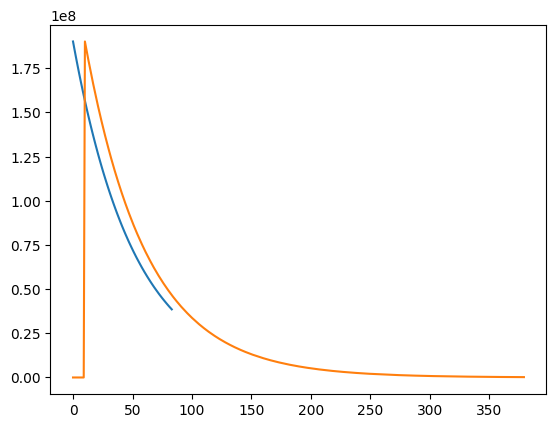

In [136]:
y = EGFP.y2-EGFP.bg*EGFP.run_time/EGFP.n_bins
plt.plot(ydata)
plt.plot(EGFP.y2-EGFP.bg*EGFP.run_time/EGFP.n_bins)

### No rescale

In [210]:
EGFP.n_photon = int(1e4)
EGFP.multi_exp_data()
y_no_bg = EGFP.y2-EGFP.bg*EGFP.run_time/EGFP.n_bins
y_with_bg = EGFP.y2
tdata,ydata,weights = trim_rescale_data(EGFP.t,y_no_bg,end = 200,rescale = False) #bg removed
p1 = initial_params(2,np.max(EGFP.y2)*EGFP.amp,EGFP.tau,rescale = False)
p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi1))



[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 337
    # data points      = 122
    # variables        = 4
    chi-square         = 130.897009
    reduced chi-square = 1.10929669
    Akaike info crit   = 16.5875528
    Bayesian info crit = 27.8036370
[[Variables]]
    c:     0 (fixed)
    A1:    93.9587400 +/- 216.805662 (230.75%) (init = 98.406)
    A2:    92.0321666 +/- 215.582830 (234.25%) (init = 99.594)
    tau1:  2.07672455 +/- 1.16433291 (56.07%) (init = 2.43)
    tau2:  3.54338200 +/- 2.49156193 (70.32%) (init = 3.07)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2)     = -1.000
    C(A1, tau2)   = 0.993
    C(A2, tau2)   = -0.992
    C(A2, tau1)   = -0.970
    C(A1, tau1)   = 0.966
    C(tau1, tau2) = 0.932


### mono-exp decay fit to EGFP

In [14]:
p1

name,value,initial value,min,max,vary
c,0.00000000,0,0.00000000,inf,True
A1,108.290000,108.28999999999999,0.00000000,inf,True
tau1,2.43000000,2.43,0.00000000,inf,True
A2,112.710000,112.71000000000001,0.00000000,inf,True
tau2,3.07000000,3.07,0.00000000,inf,True


In [15]:
EGFP.n_photon = int(1e4)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2,end = 100,rescale = False)
p1 = initial_params(3,[np.max(EGFP.y2*0.49),np.max(EGFP.y2)*0.51,1],EGFP.tau+[1],rescale = False)
#p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 234
    # data points      = 87
    # variables        = 7
    chi-square         = 90.7759006
    reduced chi-square = 1.13469876
    Akaike info crit   = 17.6962576
    Bayesian info crit = 34.9576144
##  Warning: uncertainties could not be estimated:
    c:     at boundary
[[Variables]]
    c:     1.6431e-14 +/- 7.3875e-07 (4495964146.35%) (init = 0)
    A1:    77.0644908 +/-        nan (nan%) (init = 98.49)
    tau1:  2.37168141 +/- 1.37412061 (57.94%) (init = 2.43)
    A2:    103.431386 +/-        nan (nan%) (init = 102.51)
    tau2:  3.03083233 +/-        nan (nan%) (init = 3.07)
    A3:    3.16640135 +/- 94.8844513 (2996.60%) (init = 1)
    tau3:  1.04345133 +/- 17.3852605 (1666.13%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A3, tau3)   = 0.959
    C(tau1, A3)   = 0.662
    C(tau1, tau3) = 0.554


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


In [16]:
np.sum(residual(mi1.params,tdata,ydata))

68.3370579207001

## Get 100 simulation at each point (bi-exp decay)


In [213]:
def MLEfit(N,tdata,ydata,method ='powell',r=0.1,end=100,rescale=False):
    '''Returns a pandas DataFrame of fitted parameters for ydata (EGFP.y2) (untrimmed)
       Input:
       N        N exponential/lifetime components
       tdata    untrimmed EGFP.t
       ydata    untrimmed EGFP.y2 Fluorescence decay data
       method   minimizer algorithm method
       r        trim data until ydata = r*max(ydata)
       end      not used
       rescale  True to rescale data, otherwise default False 
       
       Return:
       pd.DataFrame containing:
       rescaled amplitudes (such that they add up to 1) Ai 
       tau1, ..., tauN'''


    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r,end=end, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    par_dict.update({'red_chi2':[mi1.redchi]})
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)
MLEfit(2,EGFP.t,EGFP.sim_data[0])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


,c,A1,A2,tau1,tau2,red_chi2
0,11651.072554,0.490346,0.509654,2.426627,3.063853,1.008764


In [18]:
def MLEfit(N,tdata,ydata,method ='powell',r=0.1,end=100,rescale=False):
    '''Returns a pandas DataFrame of fitted parameters for ydata (EGFP.y2) (untrimmed)
       Input:
       N        N exponential/lifetime components
       tdata    untrimmed EGFP.t
       ydata    untrimmed EGFP.y2 Fluorescence decay data
       method   minimizer algorithm method
       r        trim data until ydata = r*max(ydata)
       end      not used
       rescale  True to rescale data, otherwise default False 
       
       Return:
       pd.DataFrame containing:
       rescaled amplitudes (such that they add up to 1) Ai 
       tau1, ..., tauN'''


    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r,end=end, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)

def val_df():
  '''Create dataframe of fitted parameters'''
  df_list = []
  for j in range(100):
    df_list.append( MLEfit(N,EGFP.t,EGFP.sim_data[j]))
    df= pd.concat(df_list).reset_index()
  return df.drop(['index'],axis =1)

N=2 #components
EGFP.y_list = np.zeros((20,100,380))
n_photon_arr = np.logspace(4,9,20)
df_list = []
for i in range(len(n_photon_arr)):
  EGFP.n_photon = n_photon_arr[i]
  EGFP.repeat_sim(100)
  EGFP.y_list[i] = EGFP.sim_data
  df =val_df()
  df_list.append(df)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.s

In [19]:
df = val_df()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.st

In [20]:
n_val_df =pd.concat(df_list,keys = range(20))

Text(0.5, 1.0, 'EGFP at low photon number')

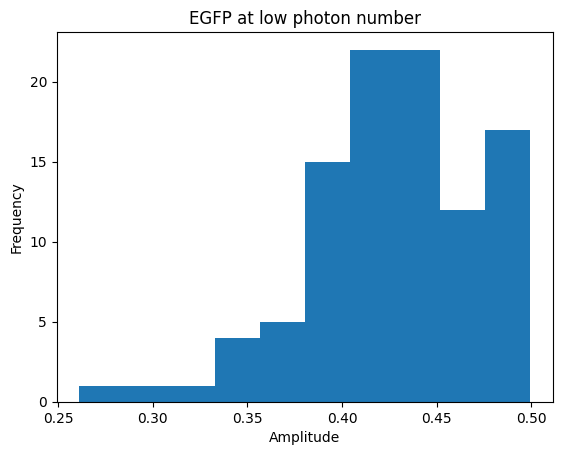

In [21]:
plt.hist(n_val_df.loc[0,'A1']) # at low phton number
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('EGFP at low photon number')

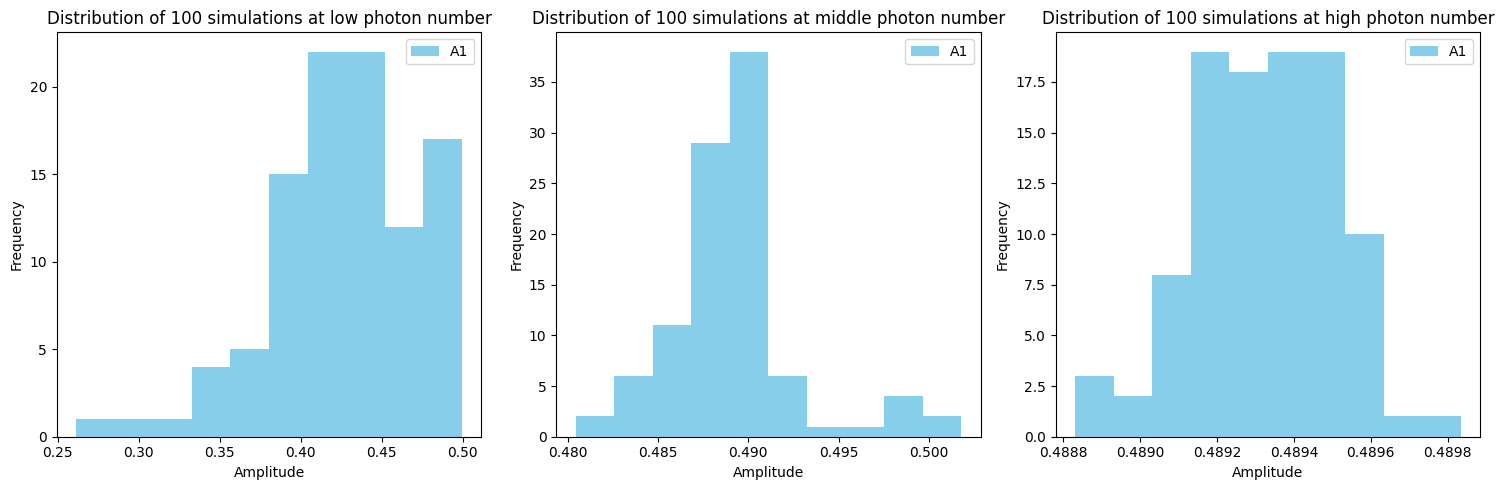

In [22]:
# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot histogram for low photon number
axs[0].hist(n_val_df.loc[0, 'A1'], bins=10, color='skyblue')  # Adjust bins if needed
axs[0].set_xlabel('Amplitude')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of 100 simulations at low photon number')
axs[0].legend(['A1'])

# Plot histogram for middle photon number
axs[1].hist(n_val_df.loc[10, 'A1'], bins=10, color='skyblue')  # Adjust bins if needed
axs[1].set_xlabel('Amplitude')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of 100 simulations at middle photon number')
axs[1].legend(['A1'])

# Plot histogram for high photon number
axs[2].hist(n_val_df.loc[19, 'A1'], bins=10, color='skyblue')  # Adjust bins if needed
axs[2].set_xlabel('Amplitude')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of 100 simulations at high photon number')
axs[2].legend(['A1'])

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [23]:
mean_df = n_val_df.groupby(level=0).mean()
std_df = n_val_df.groupby(level=0).std()

In [24]:
mean_df

,c,A1,tau1,A2,tau2
0,2.428741,0.425856,2.234030,0.574144,2.967355
1,3.591230,0.445697,2.308870,0.554303,2.982185
2,4.051022,0.465775,2.369101,0.534225,3.002061
3,7.610805,0.473273,2.387542,0.526727,2.986962
4,8.517730,0.480264,2.424631,0.519736,3.011853
5,9.850334,0.484826,2.441949,0.515174,3.011831
6,19.475136,0.487355,2.446795,0.512645,3.009107
7,24.878621,0.488342,2.445123,0.511658,3.024133
8,40.644321,0.489372,2.452058,0.510628,3.020793
9,61.643470,0.489105,2.438220,0.510895,3.038695


In [25]:
std_df

,c,A1,tau1,A2,tau2
0,3.726941,0.044735,0.294899,0.044735,0.127071
1,5.241324,0.038356,0.248635,0.038356,0.118213
2,6.837265,0.024917,0.165043,0.024917,0.102201
3,11.327245,0.019979,0.172578,0.019979,0.114246
4,15.190606,0.016125,0.142103,0.016125,0.104819
5,16.440745,0.013174,0.136047,0.013174,0.108015
6,25.596280,0.009535,0.122020,0.009535,0.105166
7,34.390268,0.008432,0.102919,0.008432,0.095124
8,48.846516,0.007127,0.101805,0.007127,0.096545
9,74.812510,0.004050,0.067153,0.004050,0.065968


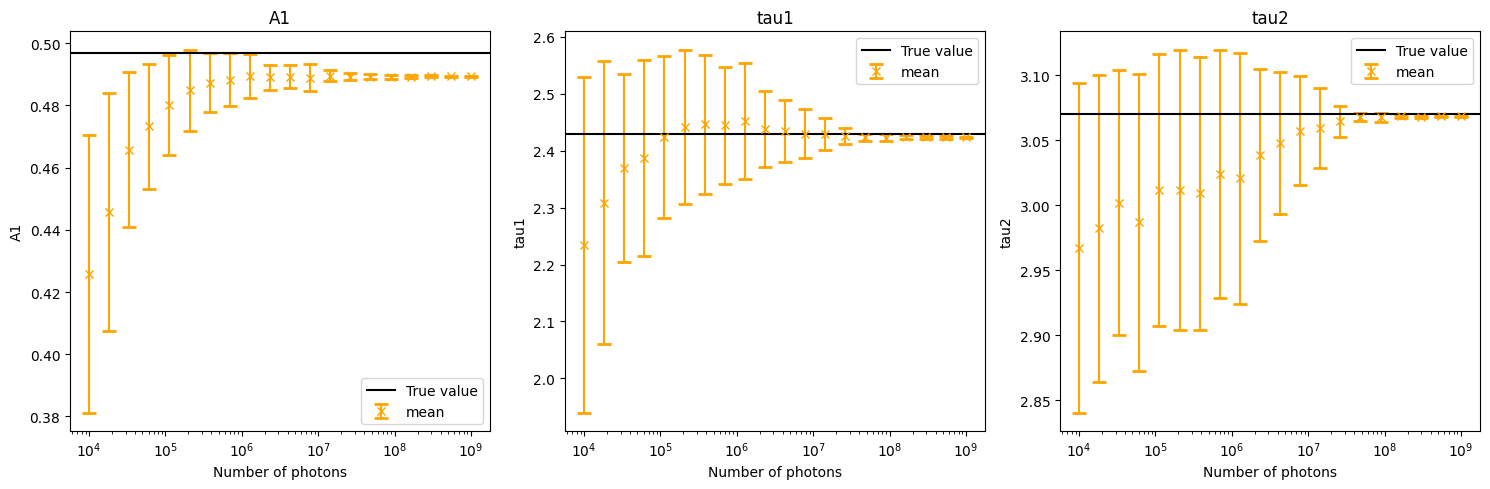

In [28]:
# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
true = [0.497,2.43,3.07]
# A1 plot
for i in range(3):
    col = ['A1','tau1','tau2'][i] #column name
    axs[i].errorbar(n_photon_arr, mean_df[col], yerr=std_df[col], fmt='x', ecolor='orange', capthick=2,
                    capsize=5, color='orange', label='mean')
    axs[i].axhline(y=true[i], color='k', linestyle='-', label='True value')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Number of photons')
    axs[i].set_ylabel(col)
    axs[i].set_title(col)
    axs[i].legend()

# # tau1 plot
# axs[1].errorbar(photon_numbers, mean_df['tau1'], yerr=std_df['tau1'], fmt='x', ecolor='orange', capthick=2,
#                 capsize=5, color='orange', label='mean')
# axs[1].axhline(y=2.43, color='k', linestyle='-', label='True value')
# axs[1].set_xscale('log')
# axs[1].set_xlabel('Number of photons')
# axs[1].set_ylabel('tau1')
# axs[1].set_title('tau1')
# axs[1].legend()

# # tau2 plot
# axs[2].errorbar(photon_numbers, mean_df['tau2'], yerr=std_df['tau2'], fmt='x', ecolor='orange', capthick=2,
#                 capsize=5, color='orange', label='mean')
# axs[2].axhline(y=3.07, color='k', linestyle='-', label='True value')
# axs[2].set_xscale('log')
# axs[2].set_xlabel('Number of photons')
# axs[2].set_ylabel('tau2')
# axs[2].set_title('tau2')
# axs[2].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
par_dict = {k:v.value for k,v in mi1.params.items()}
A_sum = sum([par_dict[f'A{j}'] for j in range(1,N+1)])
for i in range(1,N+1):
  par_dict[f'A{i}']=par_dict[f'A{i}']/A_sum

In [ ]:
par_dict

{'c': 0.06266399720935933,
 'A1': 0.43873935753300397,
 'tau1': 2.4819362211337666,
 'A2': 0.561260642466996,
 'tau2': 3.097007535851029,
 'A3': 5.810865297606327e-06,
 'tau3': 3749860.6963326423}